In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import functools
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as A
import segmentation_models as sm
import tensorflow as tf
from sklearn.metrics import confusion_matrix

Segmentation Models: using `tf.keras` framework.


In [2]:
train_df = pd.read_csv('severstal-steel-defect-detection/train.csv')
train_images_path = "severstal-steel-defect-detection/train_images"
print("Number of defective samples: ", train_df.shape[0])
train_df.head()

Number of defective samples:  7095


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [3]:
# Checking for missing values
print(train_df.isnull().sum())

num_unique = train_df['ClassId'].unique().shape[0]
# Count images with defects vs. without defects
num_defective = train_df['ImageId'].nunique()
num_total_images = len(os.listdir(train_images_path))

print(f"Total Images: {num_total_images}")
print(f"Defective Images: {num_defective}")
print(f"Non-defective Images: {num_total_images - num_defective}")
print(f"Number of unique class id (defect type): {num_unique}")

ImageId          0
ClassId          0
EncodedPixels    0
dtype: int64
Total Images: 12568
Defective Images: 6666
Non-defective Images: 5902
Number of unique class id (defect type): 4


/var/folders/84/15smpvhx2g139bpl52zzz9200000gn/T/ipykernel_6780/3967046978.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


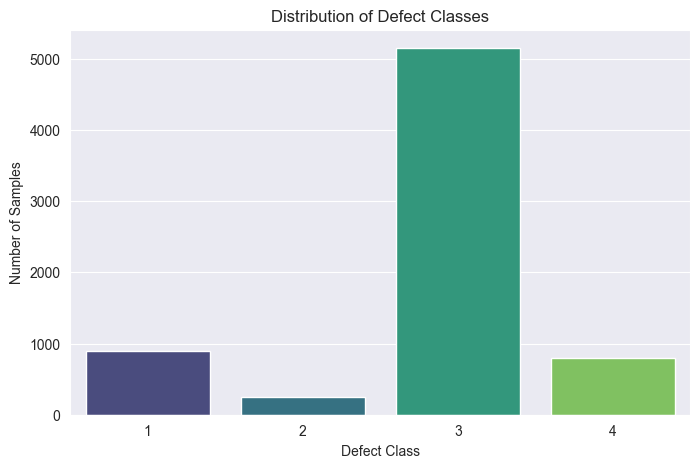

In [4]:
# Count the number of occurrences for each defect class
class_counts = train_df['ClassId'].value_counts()

# Plot bar chart
plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Defect Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Defect Classes")
plt.show()

In [5]:
def read_image(image_path, flag='IMREAD_UNCHANGED'):
    if flag == 'IMREAD_UNCHANGED':
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    elif flag == 'IMREAD_GRAYSCALE':
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    else:
        raise ValueError("Invalid flag. Use 'IMREAD_UNCHANGED' or 'IMREAD_GRAYSCALE'.")

    if img is None:
        print(f"⚠️ Warning: Unable to read {image_path}")
        return np.zeros((256, 1600), dtype=np.uint8)  # Return blank image

    return img

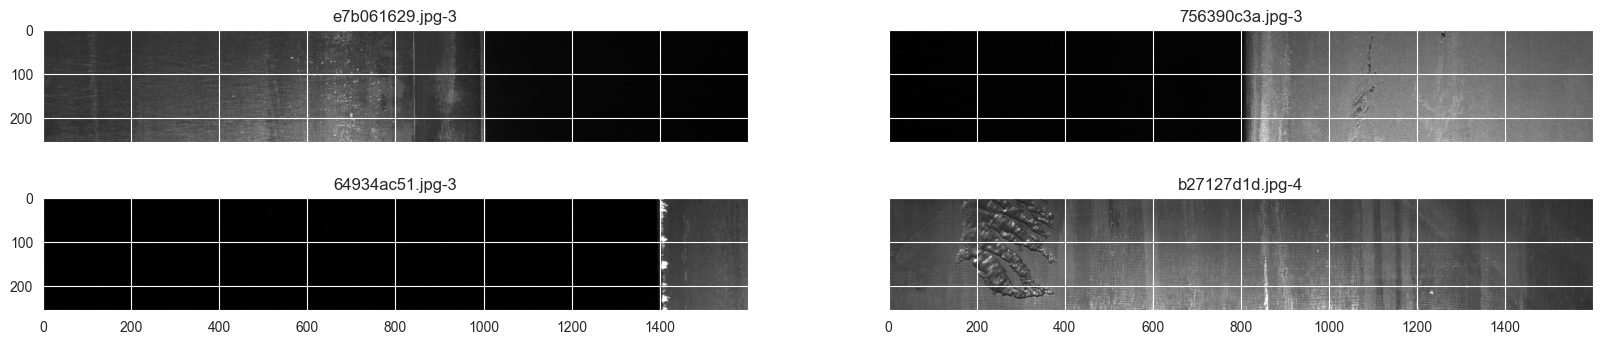

In [6]:
fig, axs = plt.subplots(2,2,figsize=(20,4), sharex=True,sharey=True)
for i in range(4):
    row_id = np.random.randint(0,train_df.shape[0])
    image_id, class_id = train_df['ImageId'].iloc[row_id], train_df['ClassId'].iloc[row_id]
    image_path = os.path.join(train_images_path, image_id)
    sample_image = read_image(image_path)
    axs[i//2][i%2].imshow(sample_image)
    axs[i//2][i%2].set_title(f'{image_id}-{class_id}')
plt.subplots_adjust()
plt.show()

 Found 5902 non-defective images.


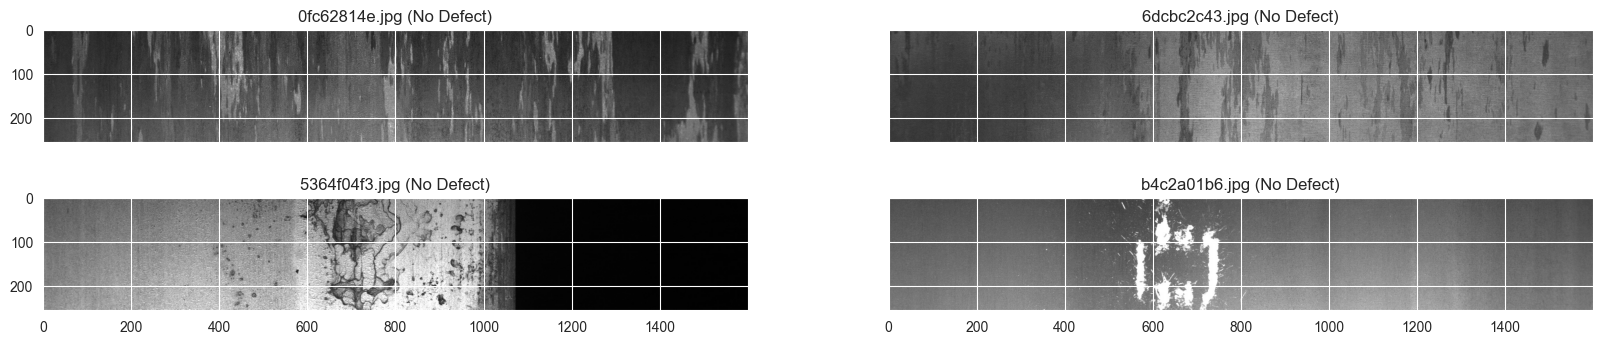

In [7]:
# Get all image filenames in the train images folder
all_images = set(os.listdir(train_images_path))
defective_images = set(train_df['ImageId'].unique())

# Get non-defective images by subtracting the defective ones
non_defective_images = list(all_images - defective_images)
print(f" Found {len(non_defective_images)} non-defective images.")

if len(non_defective_images) == 0:
    print(" No non-defective images found! Check the dataset folder structure.")
else:
    fig, axs = plt.subplots(2, 2, figsize=(20, 4), sharex=True, sharey=True)

    for i in range(4):
        row_id = np.random.randint(0, len(non_defective_images))  # Select from defect-free images
        image_id = non_defective_images[row_id]
        image_path = os.path.join(train_images_path, image_id)

        # Debug: Check if the file exists
        if not os.path.exists(image_path):
            print(f" Skipping {image_id} (File not found)")
            continue

        sample_image = read_image(image_path)

        # Debug: Check if image is valid
        if sample_image is None or not isinstance(sample_image, np.ndarray):
            print(f" Skipping {image_id} (Invalid image)")
            continue

        axs[i//2, i%2].imshow(sample_image, cmap='gray')
        axs[i//2, i%2].set_title(f'{image_id} (No Defect)')

    plt.subplots_adjust()
    plt.show()

In [8]:
def transform(encoded_pixel, width=1600, height=256, fill_value=1):
    "return mask of image size (height*width)"
    encoded_pixel_list = list(map(lambda x: int(x), encoded_pixel.split(' ')))
    n = len(encoded_pixel_list)
    encoded_pixel_list = [(encoded_pixel_list[i], encoded_pixel_list[i+1]) for i in range(0, n, 2)]
    #create a flat array of size width*height
    mask = np.zeros(height*width)
    for start, offset in encoded_pixel_list:
        mask[start-1:start+offset-1] = fill_value #minus 1 is because encoded pixel starts from 1 and not 0
    #transpose operation is necessary to match pixel number format
    mask = mask.reshape(width, height)
    return mask.T

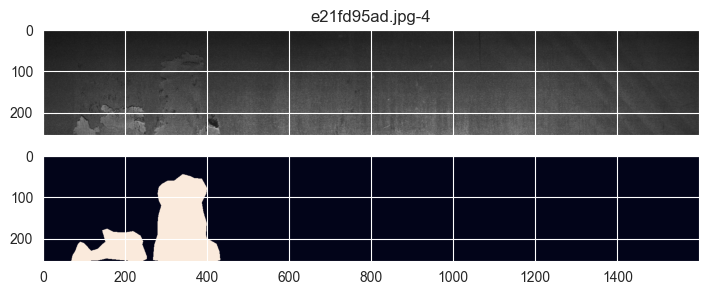

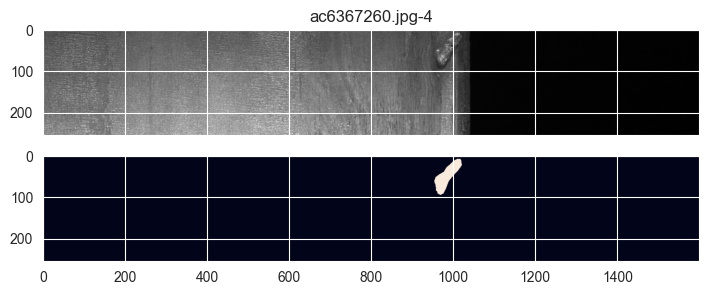

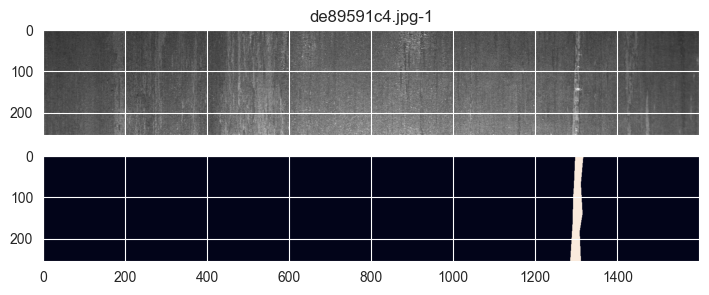

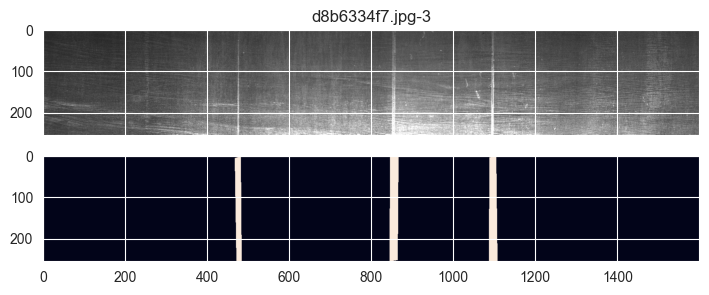

In [9]:
for i in range(4):
    row_id = np.random.randint(0,train_df.shape[0])
    image_id, class_id, encoded_pixel = train_df.iloc[row_id, :3]
    #read image file from path
    image = read_image(os.path.join(train_images_path, image_id))
    height, width, channel = image.shape
    #return mask given encoded pixel
    mask = transform(encoded_pixel, width, height)
    #plot image and corresponding mask
    fig, axs = plt.subplots(2,1,figsize=(11,3),sharex=True)
    axs[0].imshow(image)
    axs[1].imshow(mask)
    axs[0].set_title(f'{image_id}-{class_id}')
    plt.show()

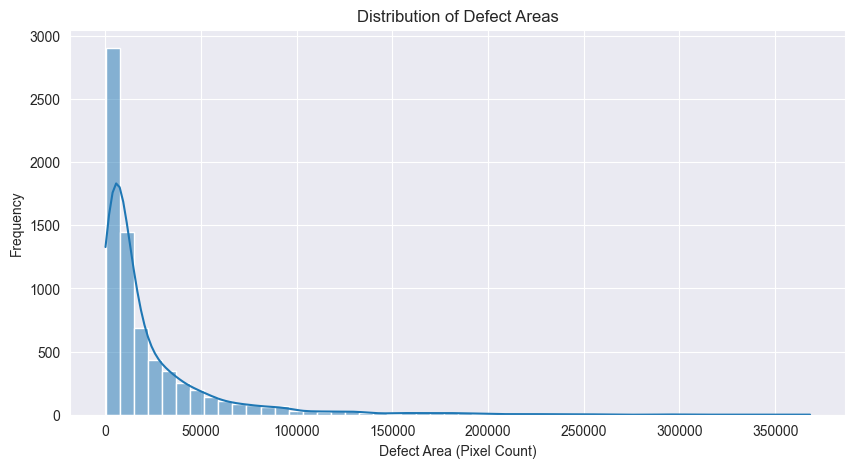

In [10]:
train_df['Defect_Area'] = train_df['EncodedPixels'].apply(lambda x: sum(map(int, x.split()[1::2])) if isinstance(x, str) else 0)

plt.figure(figsize=(10,5))
sns.histplot(train_df['Defect_Area'], bins=50, kde=True)
plt.xlabel("Defect Area (Pixel Count)")
plt.ylabel("Frequency")
plt.title("Distribution of Defect Areas")
plt.show()

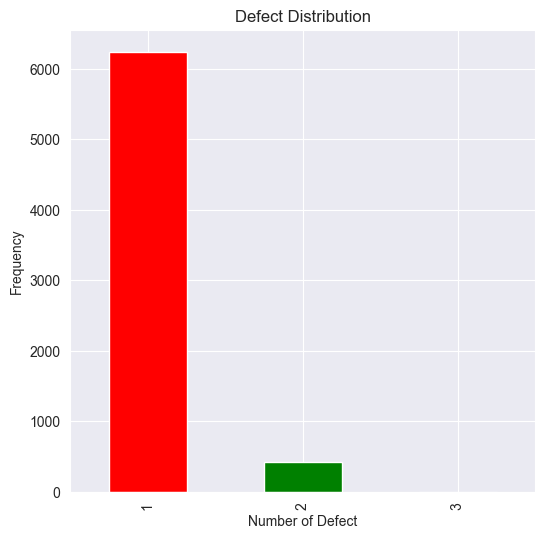

In [11]:
train_df['ImageId'].value_counts().value_counts().sort_index().plot(kind='bar', figsize=(6,6), color=['r', 'g', 'y'])
plt.xlabel('Number of Defect')
plt.ylabel('Frequency')
plt.title("Defect Distribution")
plt.show()

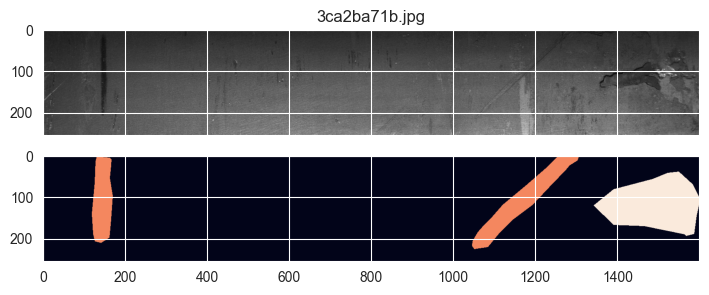

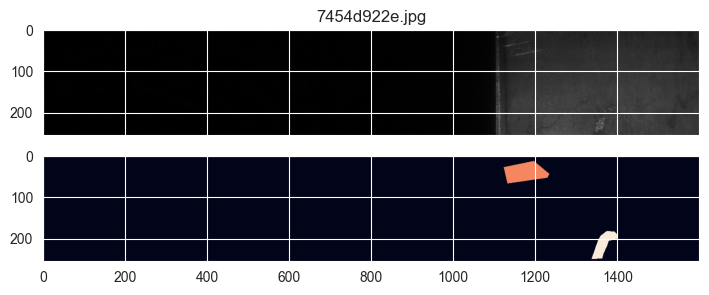

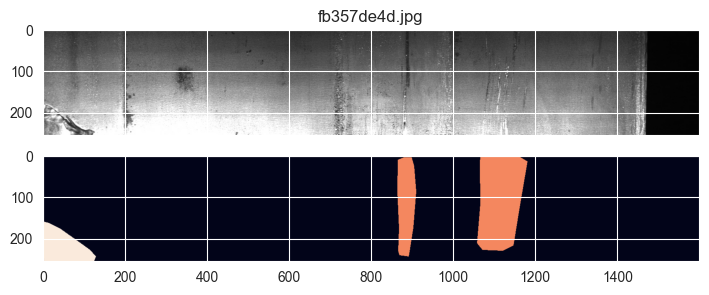

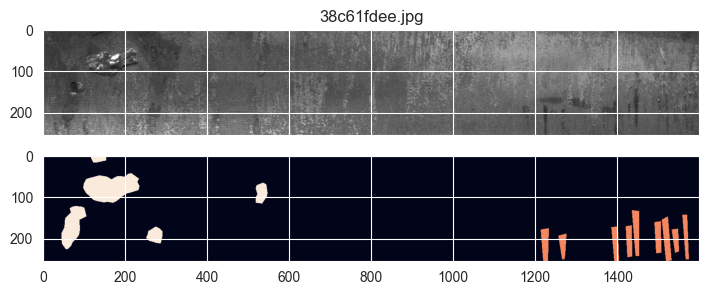

In [12]:
series = train_df['ImageId'].value_counts()
image_id_with_more_than_1_defect = series[(series == 2) | (series == 3)].index

for i in range(4):
    row_id = np.random.randint(0,len(image_id_with_more_than_1_defect))
    image_id = image_id_with_more_than_1_defect[row_id]
    df = train_df[train_df['ImageId']==image_id][['ClassId', 'EncodedPixels']]
    #read image file from path
    image = read_image(os.path.join(train_images_path, image_id))
    height, width, channel = image.shape
    #return mask given encoded pixel
    if df.shape[0] > 1:
        mask = [transform(df['EncodedPixels'].iloc[j], width, height, df['ClassId'].iloc[j]) for j in range(df.shape[0])]
        mask = functools.reduce(lambda x, y: x+y, mask)
    else:
        mask = transform(df['EncodedPixels'], width, height, df['ClassId'])
    #plot image and corresponding mask
    fig, axs = plt.subplots(2,1,figsize=(11,3),sharex=True)
    axs[0].imshow(image)
    axs[1].imshow(mask)
    axs[0].set_title(f'{image_id}')
    plt.show()

# Model Training

In [13]:
CSV_PATH = 'severstal-steel-defect-detection/train.csv'

# Load train.csv
train_df = pd.read_csv(CSV_PATH)
print(f"Dataset Loaded: {train_df.shape}")

# Function to decode RLE into a binary mask
def rle_decode(encoded_pixel, shape=(256, 1600)):
    """Convert RLE to binary mask"""
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    if isinstance(encoded_pixel, str):  # Ignore NaNs
        encoded_pixel_list = list(map(int, encoded_pixel.split()))
        starts, lengths = encoded_pixel_list[0::2], encoded_pixel_list[1::2]
        for start, length in zip(starts, lengths):
            mask[start - 1: start + length - 1] = 1
    return mask.reshape(shape).T  # Transpose to match image orientation

# Function to load images and masks
def load_data(image_ids):
    images, masks = [], []
    for image_id in image_ids:
        image_path = os.path.join(train_images_path, image_id)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (256, 256)) / 255.0  # Normalize

        # Create empty mask
        mask = np.zeros((256, 256), dtype=np.uint8)

        # Get defect masks
        for _, row in train_df[train_df["ImageId"] == image_id].iterrows():
            defect_mask = rle_decode(row["EncodedPixels"], (256, 1600))
            defect_mask = cv2.resize(defect_mask, (256, 256))
            mask = np.maximum(mask, defect_mask)  # Merge masks

        images.append(image)
        masks.append(mask)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.uint8)
    masks = np.expand_dims(masks, axis=-1)  # Add channel dimension
    return images, masks

# Get unique images
image_ids = train_df["ImageId"].unique()
X, Y = load_data(image_ids)
print(f"Loaded {len(X)} images with masks")

Dataset Loaded: (7095, 3)
Loaded 6666 images with masks


In [14]:
# Split into 80% Train, 20% Validation
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Training Samples: {len(X_train)}, Validation Samples: {len(X_val)}")

Training Samples: 5332, Validation Samples: 1334


In [15]:
X_train = X_train.astype("float32") / 255.0  # Normalize to [0,1]
X_val = X_val.astype("float32") / 255.0

Y_train = Y_train.astype("float32")  # Ensure masks are float32
Y_val = Y_val.astype("float32")

In [16]:

def focal_loss(alpha=0.8, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = 1e-6  # Avoid log(0)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)  # ✅ Uses TensorFlow directly
        pt = tf.where(y_true == 1, y_pred, 1 - y_pred)  # Probabilities for true class
        return -tf.reduce_mean(alpha * tf.pow(1 - pt, gamma) * tf.math.log(pt))
    return loss

In [17]:
# Function to compute and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    # Flatten masks (convert from 2D to 1D arrays)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Convert predictions to binary (Threshold = 0.5)
    y_pred = (y_pred > 0.5).astype(np.uint8)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background (0)", "Foreground (1)"], yticklabels=["Background (0)", "Foreground (1)"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [18]:
train_transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.2),
    A.GaussianBlur(p=0.2),
])

# Function to Apply Augmentations & Ensure Correct Size
def apply_augmentations(X, Y):
    X_aug, Y_aug = [], []
    for img, mask in zip(X, Y):
        augmented = train_transform(image=img, mask=mask)
        X_aug.append(augmented["image"])
        Y_aug.append(augmented["mask"])
    return np.array(X_aug, dtype=np.float32) / 255.0, np.array(Y_aug, dtype=np.float32) / 255.0  # Normalize

# Apply Augmentations to Training Data
X_train_aug, Y_train_aug = apply_augmentations(X_train, Y_train)

# ✅ Resize Validation Data Using TensorFlow
def resize_validation_data(image, mask):
    image = tf.image.resize(image, (128, 128)) / 255.0
    mask = tf.image.resize(mask, (128, 128)) / 255.0
    return image, mask

# Convert to TensorFlow Dataset (Ensure Correct Size)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_aug, Y_train_aug))
train_dataset = train_dataset.cache().shuffle(256).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.map(resize_validation_data).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Define U-Net Model with MobileNetV2 Backbone
BACKBONE = "mobilenetv2"
model_with_aug = sm.Linknet(BACKBONE, encoder_weights="imagenet", input_shape=(128, 128, 3), classes=1, activation="sigmoid")

# Compile Model
model_with_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Faster Convergence
    loss=focal_loss(),
    metrics=[sm.metrics.iou_score, sm.metrics.f1_score]
)

# Train Model
history_with_aug = model_with_aug.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Reduce epochs since LR is higher
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]  # ✅ Removed redundant batch_size
)

# Save Model
model_with_aug.save("optimized_model_with_aug.h5")

Epoch 1/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 223s 317ms/step - f1-score: 4.7166e-04 - iou_score: 2.3590e-04 - loss: 0.0105 - val_f1-score: 4.4517e-04 - val_iou_score: 2.2265e-04 - val_loss: 0.0028
Epoch 2/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 223s 334ms/step - f1-score: 4.6189e-04 - iou_score: 2.3101e-04 - loss: 3.1518e-05 - val_f1-score: 4.3388e-04 - val_iou_score: 2.1700e-04 - val_loss: 0.0020
Epoch 3/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 205s 308ms/step - f1-score: 4.6146e-04 - iou_score: 2.3080e-04 - loss: 1.0388e-05 - val_f1-score: 4.4607e-04 - val_iou_score: 2.2310e-04 - val_loss: 0.0011
Epoch 4/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 213s 319ms/step - f1-score: 4.5903e-04 - iou_score: 2.2958e-04 - loss: 4.9560e-06 - val_f1-score: 4.7112e-04 - val_iou_score: 2.3563e-04 - val_loss: 7.5159e-04
Epoch 5/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 238s 357ms/step - f1-score: 4.5943e-04 - iou_score: 2.2979e-04 - loss: 2.7550e-06 - val_f1-score: 4.8761e-04 - val_iou_score: 2.4388e-04 - val_loss: 3.1702e-04
Epoch 6/10
667/6

In [19]:
# Convert Raw Data to TensorFlow Dataset (Without Augmentations)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

# Resize and Normalize Training Data (No Augmentations)
train_dataset_no_aug = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset_no_aug = train_dataset_no_aug.map(lambda x, y: (tf.image.resize(x, (128, 128)) / 255.0, tf.image.resize(y, (128, 128)) / 255.0))
train_dataset_no_aug = train_dataset_no_aug.shuffle(256).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Resize and Normalize Validation Data
val_dataset_no_aug = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset_no_aug = val_dataset_no_aug.map(lambda x, y: (tf.image.resize(x, (128, 128)) / 255.0, tf.image.resize(y, (128, 128)) / 255.0))
val_dataset_no_aug = val_dataset_no_aug.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Define Model Without Augmentations
model_no_aug = sm.Unet("mobilenetv2", encoder_weights="imagenet", input_shape=(128, 128, 3), classes=1, activation="sigmoid")

# Compile Model
model_no_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(),
    metrics=[sm.metrics.iou_score, sm.metrics.f1_score]
)

# Train Model Without Augmentations
history_no_aug = model_no_aug.fit(
    train_dataset_no_aug,
    validation_data=val_dataset_no_aug,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
)

# Save Model
model_no_aug.save("model_without_aug.h5")

Epoch 1/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 323s 443ms/step - f1-score: 4.6991e-04 - iou_score: 2.3503e-04 - loss: 0.0030 - val_f1-score: 4.6463e-04 - val_iou_score: 2.3239e-04 - val_loss: 1.9718e-04
Epoch 2/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 295s 442ms/step - f1-score: 4.6653e-04 - iou_score: 2.3333e-04 - loss: 9.1770e-06 - val_f1-score: 4.4543e-04 - val_iou_score: 2.2278e-04 - val_loss: 1.3022e-04
Epoch 3/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 288s 431ms/step - f1-score: 4.6101e-04 - iou_score: 2.3058e-04 - loss: 3.0883e-06 - val_f1-score: 4.3282e-04 - val_iou_score: 2.1647e-04 - val_loss: 5.3132e-05
Epoch 4/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 288s 432ms/step - f1-score: 4.5632e-04 - iou_score: 2.2823e-04 - loss: 1.4858e-06 - val_f1-score: 4.4081e-04 - val_iou_score: 2.2047e-04 - val_loss: 1.0811e-05
Epoch 5/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 290s 434ms/step - f1-score: 4.5694e-04 - iou_score: 2.2854e-04 - loss: 8.3097e-07 - val_f1-score: 4.4720e-04 - val_iou_score: 2.2367e-04 - val_loss: 3.5177e-06
Epoc

In [20]:
# Evaluate Model Without Augmentation
loss_no_aug, iou_no_aug, f1_no_aug = model_no_aug.evaluate(val_dataset_no_aug)
print(f"Model Without Augmentation - Loss: {loss_no_aug:.4f}, IoU Score: {iou_no_aug:.4f}, F1 Score: {f1_no_aug:.4f}")

# Evaluate Model With Augmentation
loss_aug, iou_aug, f1_aug = model_with_aug.evaluate(val_dataset_no_aug)
print(f"Model With Augmentation - Loss: {loss_aug:.4f}, IoU Score: {iou_aug:.4f}, F1 Score: {f1_aug:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 182ms/step - f1-score: 4.4318e-04 - iou_score: 2.2166e-04 - loss: 9.5318e-08
Model Without Augmentation - Loss: 0.0000, IoU Score: 0.0002, F1 Score: 0.0005
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - f1-score: 4.4257e-04 - iou_score: 2.2136e-04 - loss: 2.8680e-07
Model With Augmentation - Loss: 0.0000, IoU Score: 0.0002, F1 Score: 0.0005


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


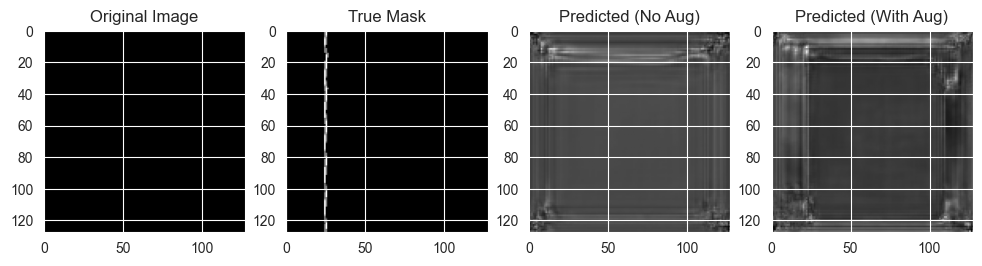

In [21]:
import matplotlib.pyplot as plt

# Pick a sample from the validation set
sample_image, sample_mask = next(iter(val_dataset_no_aug))

# Predict using both models
pred_mask_no_aug = model_no_aug.predict(tf.expand_dims(sample_image[0], axis=0))
pred_mask_aug = model_with_aug.predict(tf.expand_dims(sample_image[0], axis=0))

# Plot Original, Ground Truth, and Predictions
fig, axes = plt.subplots(1, 4, figsize=(12, 5))
axes[0].imshow(sample_image[0])  # Original Image
axes[0].set_title("Original Image")

axes[1].imshow(sample_mask[0], cmap="gray")  # Ground Truth Mask
axes[1].set_title("True Mask")

axes[2].imshow(pred_mask_no_aug[0], cmap="gray")  # Prediction Without Augmentation
axes[2].set_title("Predicted (No Aug)")

axes[3].imshow(pred_mask_aug[0], cmap="gray")  # Prediction With Augmentation
axes[3].set_title("Predicted (With Aug)")

plt.show()

In [22]:
def plot_segmentation_results(images, true_masks, predicted_masks, title="Segmentation Results"):
    num_samples = len(images)

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        axes[i, 0].imshow(images[i])  # Original Image
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(true_masks[i], cmap="gray")  # True Mask
        axes[i, 1].set_title("True Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(predicted_masks[i], cmap="gray")  # Predicted Mask
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


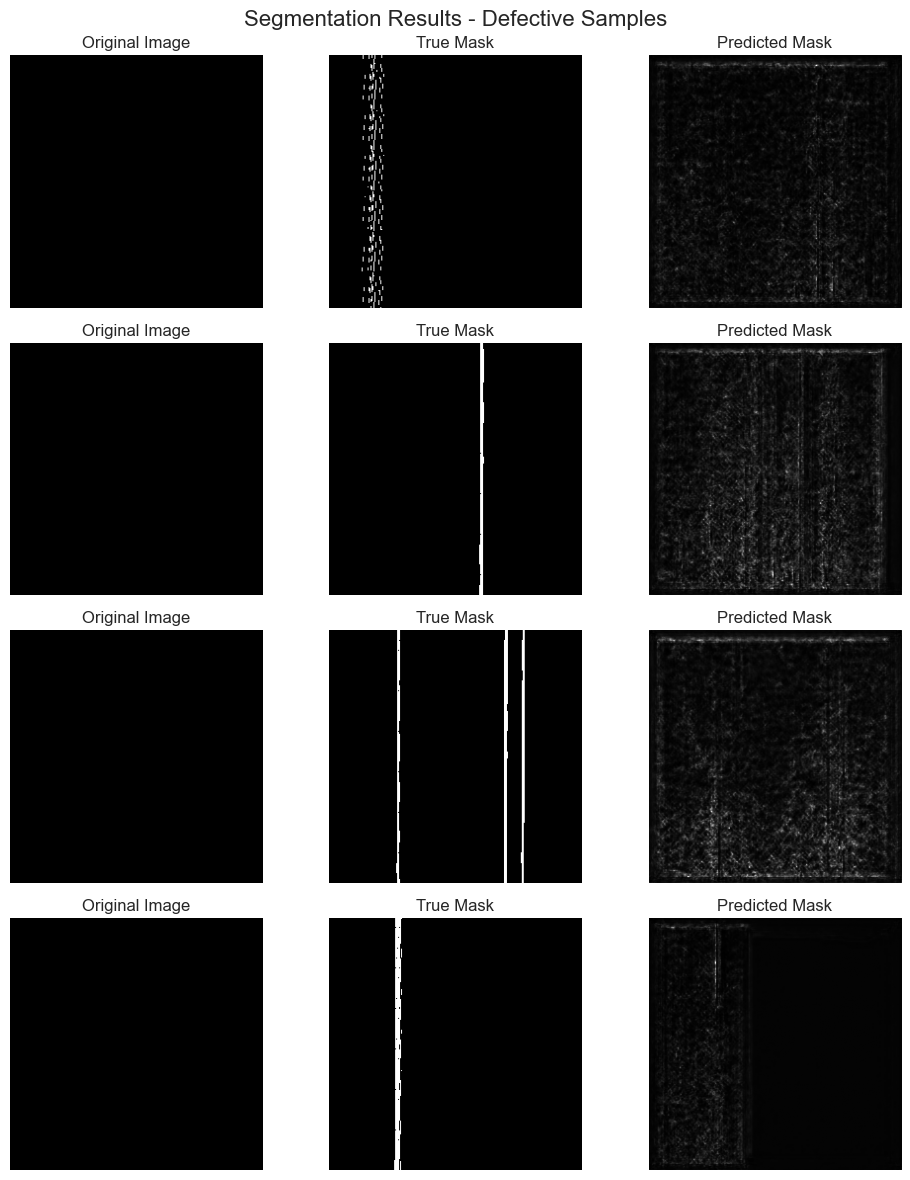

In [23]:
# Select images with defects (non-empty masks)
defect_indices = [i for i in range(len(Y_val)) if np.sum(Y_val[i]) > 0]

# Select a few samples (limit to 4-5 for visualization)
num_samples = min(4, len(defect_indices))
sample_indices = np.random.choice(defect_indices, num_samples, replace=False)

# Extract selected images, true masks, and predictions
sample_images = X_val[sample_indices]
sample_true_masks = Y_val[sample_indices]
sample_pred_masks = model_no_aug.predict(sample_images)

# Plot results
plot_segmentation_results(sample_images, sample_true_masks, sample_pred_masks, title="Segmentation Results - Defective Samples")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


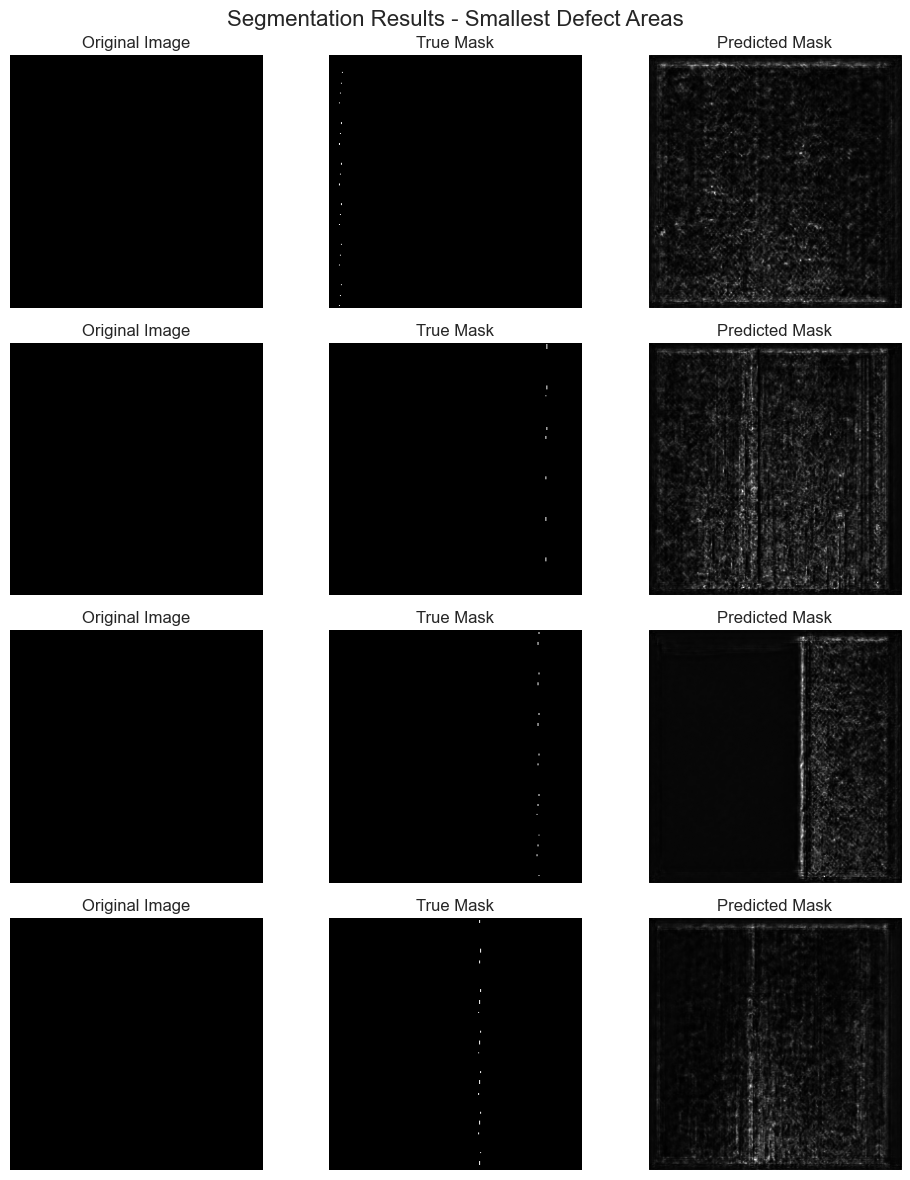

In [24]:
# ✅ Find the 4 masks with the smallest defect areas
num_samples = 4  # Choose how many samples to visualize
smallest_defects_indices = np.argsort(np.sum(Y_val, axis=(1,2,3)))[:num_samples]  # Sort and take the lowest

# ✅ Extract selected images, true masks, and predictions
sample_images_small_defects = X_val[smallest_defects_indices]
sample_true_masks_small_defects = Y_val[smallest_defects_indices]
sample_pred_masks_small_defects = model_no_aug.predict(sample_images_small_defects)

# ✅ Plot results
plot_segmentation_results(
    sample_images_small_defects,
    sample_true_masks_small_defects,
    sample_pred_masks_small_defects,
    title="Segmentation Results - Smallest Defect Areas"
)